<h2> rotina para cortar os dados do hycom e ajustar no mesmo intervalo te tempo da boia</h2>

<p> Serie 1 - [2016-11-19 06:00:00, 2017-04-14 12:00:00]</p>
<p> Serie 2 - [2017-06-16 09:00:00, 2017-09-07 02:00:00]</p>

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime as dtime

In [2]:
from low_pass_filter import butter_low_pass_filter

In [3]:
from numpy import pi

In [4]:
def rotaciona_corrente(zonal, meridional, phi):
    
    phi = np.deg2rad(phi)
    ul = zonal* np.cos(phi) + meridional * np.sin(phi)
    vl = -zonal * np.sin(phi) + meridional * np.cos(phi)
    
    return ul, vl

In [5]:
cd '/home/gus/Documentos/mestrado/dados-mestrado/dados-hycom/csv'

/home/gus/Documentos/mestrado/dados-mestrado/dados-hycom/csv


In [6]:
%matplotlib inline

In [7]:
lista1 = sorted(glob('*zonal.csv'))

In [8]:
lista2 = sorted(glob('*meridional.csv'))

In [9]:
dfu = pd.read_csv(lista1[0], skip_blank_lines=True,\
                  error_bad_lines=False, delimiter= ';')

dfv = pd.read_csv(lista2[0], skip_blank_lines=True,\
                  error_bad_lines=False, delimiter=';')

lista_dfu = [dfu]
lista_dfv = [dfv]

for file1, file2 in zip(lista1[1:], lista2[1:]):

    data1 = pd.read_csv(file1, skip_blank_lines=True,
                        error_bad_lines=False, delimiter=";")

    data2 = pd.read_csv(file2, skip_blank_lines=True,
                        error_bad_lines=False, delimiter=";")

    lista_dfu.append(data1)
    lista_dfv.append(data2)

In [10]:
dfu = pd.concat(lista_dfu, ignore_index=True)
dfv = pd.concat(lista_dfv, ignore_index=True)

In [11]:
del data1, data2, lista_dfu, lista_dfv, lista1, lista2

In [12]:
time = np.copy(dfu.time)

In [13]:
time = [dtime.strptime(ii, "%Y-%m-%d %H:%M:%S") for ii in time]
time = np.array(time)

In [14]:
dfu.drop(['time'], inplace=True, axis=1)
dfv.drop(['time'], inplace=True, axis=1)

In [15]:
time.min(), time.max()

(datetime.datetime(2016, 12, 2, 12, 0), datetime.datetime(2017, 9, 29, 21, 0))

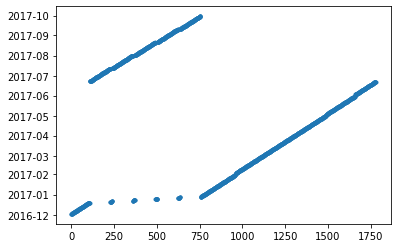

In [16]:
plt.plot(time,'.') #checando para ver se há buracos

### m/s para cm/s

In [17]:
dfu = dfu *100;
dfv = dfv *100;

### Rotacao dos dados em relaçao a costa

In [18]:
ul, vl = rotaciona_corrente(dfu, dfv, 60)

## realocando os dados do hycom para filtrar

In [19]:
tempoAjustado = pd.date_range(start='2016-12-01 12:00',\
                              end='2017-12-31 09:00', freq='3H')


ulAjustado = np.zeros([len(tempoAjustado), 4])
vlAjustado = np.zeros([len(tempoAjustado), 4])

ulAjustado[:] = np.NaN
vlAjustado[:] =  np.NaN

for line in range(len(time)):

    index = np.nonzero(tempoAjustado == time[line])

    ulAjustado[index[0], :] = ul.iloc[line, :]
    vlAjustado[index[0], :] = vl.iloc[line, :]

In [20]:
len(tempoAjustado), len(ulAjustado)

(3160, 3160)

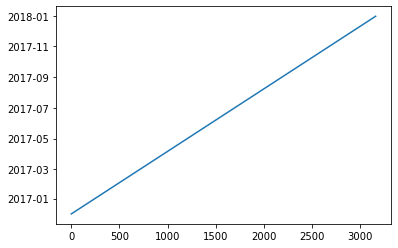

In [21]:
plt.plot(tempoAjustado)

### criando um ruido branco

In [22]:
Length = len(vlAjustado)
Noise = [np.cos(pi*k) for k in range(Length)]

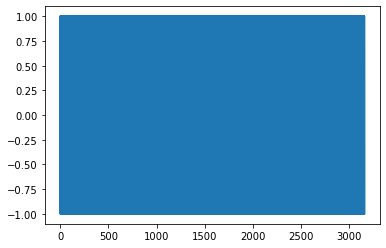

In [23]:
plt.plot(Noise,'-')

### criando as matrizes para receber os dados filtrados

In [24]:
ulFiltrado = np.zeros_like(ulAjustado)
vlFiltrado = np.zeros_like(vlAjustado)

ulFiltrado[:] = np.NaN
vlFiltrado[:] = np.NaN

# trocando nan por 0
vlAjustado[np.isnan(vlAjustado)] = 0
ulAjustado[np.isnan(ulAjustado)] = 0

### filtrando os dados

In [25]:
for column in range(4):

    # add ruido branco nos dados
    vlAjustado[:, column] += Noise
    ulAjustado[:, column] += Noise

    
    #filtragem
    y = butter_low_pass_filter(vlAjustado[:, column], 2, 12)
    x = butter_low_pass_filter(ulAjustado[:, column], 2, 12)

    ulFiltrado[:, column] = x
    vlFiltrado[:, column] = y


In [26]:
tempoSemBuraco = pd.date_range(start='2016-12-01 12:00', end='2017-12-31 09:00', freq='1H')

## remocao do ruido dos dados originais e filtrados

In [27]:
for ii in range(4):
    ulAjustado[:, ii] -= Noise
    vlAjustado[:, ii] -= Noise
    
    ulFiltrado[:, ii] -= Noise
    vlFiltrado[:, ii] -= Noise
    

In [28]:
ulAjustado[ulAjustado==0] = np.NaN
vlAjustado[vlAjustado==0] = np.NaN


ulFiltrado[ulFiltrado==0] = np.NaN
vlFiltrado[vlFiltrado==0] = np.NaN

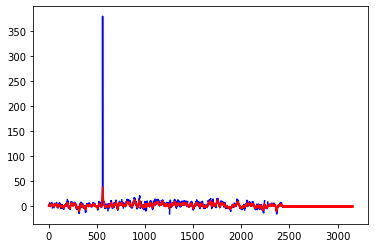

In [29]:
plt.plot(ulAjustado[:,3], '-b')
plt.plot(ulFiltrado[:,3], '-r')

## realocamento dos dados

In [30]:
ulFiltradoSemBuraco = np.zeros([len(tempoSemBuraco), 4])
vlFiltradoSemBuraco = np.zeros([len(tempoSemBuraco), 4])

ulFiltradoSemBuraco[:] = np.NaN
vlFiltradoSemBuraco[:] = np.NaN


for ii in range(len(tempoAjustado)):

    index = np.nonzero(tempoSemBuraco == tempoAjustado[ii])

    ulFiltradoSemBuraco[index[0], :] = ulFiltrado[ii, :]
    vlFiltradoSemBuraco[index[0], :] = vlFiltrado[ii, :]
    

In [31]:
if len(ulFiltradoSemBuraco) == len(tempoSemBuraco):
    print('realocamento feito com sucesso!')

realocamento feito com sucesso!


### cortando os dados fitrados do hycom 

In [32]:
limInferior = dtime.strptime('2016-11-18 20:00:00','%Y-%m-%d %H:%M:%S')
limSuperior = dtime.strptime('2017-09-19 08:00:00','%Y-%m-%d %H:%M:%S')

In [33]:
condtime = ((limInferior <= tempoSemBuraco) & (tempoSemBuraco<= limSuperior))

In [34]:
dfu_cortado = pd.DataFrame(ulFiltradoSemBuraco[condtime])
dfv_cortado = pd.DataFrame(vlFiltradoSemBuraco[condtime])

### interpolando os dados 

In [35]:
dfu_cortado.interpolate(method='polynomial', order=2,limit=8, inplace=True)
dfv_cortado.interpolate(method='polynomial', order=2,limit=8, inplace=True)

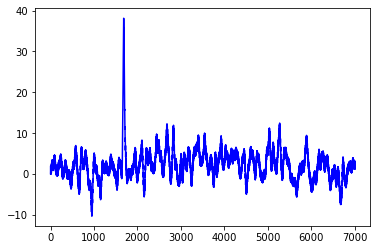

In [36]:
plt.plot(dfu_cortado.iloc[:,3],'-b')

In [37]:
dfu[dfu==0]=np.NaN
dfv[dfv==0]=np.NaN

In [38]:
dfu_cortado[dfu_cortado==0]=np.NaN
dfv_cortado[dfv_cortado==0]=np.NaN

In [39]:
column_names = np.copy(dfu.columns)
dfu_cortado.columns = column_names
dfv_cortado.columns = column_names

In [40]:
dfu_cortado['time'] = tempoSemBuraco[condtime];
dfv_cortado['time'] = tempoSemBuraco[condtime];

In [42]:
dfu_cortado.head()

,8m,16m,32m,40m,time
0,0.073046,0.076505,0.058715,0.041306,2016-12-01 12:00:00
1,1.345355,1.359159,1.332073,1.305007,2016-12-01 13:00:00
2,1.992463,2.016933,1.981405,1.944422,2016-12-01 14:00:00
3,2.014371,2.049828,2.006711,1.959553,2016-12-01 15:00:00
4,1.411078,1.457844,1.407990,1.350398,2016-12-01 16:00:00


In [43]:
pwd

'/home/gus/Documentos/mestrado/dados-mestrado/dados-hycom/csv'

In [44]:
dfu_cortado.to_csv('../dado_filtrado/hycom_ul_filtrado_total.csv', sep=';',index= False)
dfv_cortado.to_csv('../dado_filtrado/hycom_vl_filtrado_total.csv', sep=';',index= False)

In [45]:
dfu_cortado.time

0      2016-12-01 12:00:00
1      2016-12-01 13:00:00
2      2016-12-01 14:00:00
3      2016-12-01 15:00:00
4      2016-12-01 16:00:00
               ...        
7000   2017-09-19 04:00:00
7001   2017-09-19 05:00:00
7002   2017-09-19 06:00:00
7003   2017-09-19 07:00:00
7004   2017-09-19 08:00:00
Name: time, Length: 7005, dtype: datetime64[ns]

### Separando as duas séries

In [ ]:
"""
limInferior1 = dtime.strptime('2016-11-19 06:00:00', "%Y-%m-%d %H:%M:%S")
limSuperior1 = dtime.strptime('2017-04-14 12:00:00', "%Y-%m-%d %H:%M:%S")

limInferior2 = dtime.strptime('2017-06-16 09:00:00', "%Y-%m-%d %H:%M:%S")
limSuperior2 = dtime.strptime('2017-09-07 02:00:00', "%Y-%m-%d %H:%M:%S")
""";

In [ ]:
"""
condtime1 = ((limInferior1 <= dfu_cortado.time) & (dfu_cortado.time <= limSuperior1))
condtime2 = ((limInferior2 <= dfu_cortado.time) & (dfu_cortado.time <= limSuperior2))
""";

In [ ]:
"""
hycomZonal1 = dfu_cortado.loc[condtime1, :]
hycomZonal2 = dfu_cortado.loc[condtime2, :]


hycomMeridional1 = dfv_cortado.loc[condtime1, :]
hycomMeridional2 = dfv_cortado.loc[condtime2, :]
""";

In [ ]:
#hycomZonal1.head(2)

In [ ]:
#hycomZonal1.tail(2)

In [ ]:
#hycomZonal2.head(2)

In [ ]:
#hycomZonal2.tail(2)

In [ ]:
"""

hycomZonal1.to_csv('HycomZonal1.csv', sep=';',index= False)
hycomZonal2.to_csv('HycomZonal2.csv', sep=';',index= False)


hycomMeridional1.to_csv('HycomMeridional1.csv', sep=';',index= False)
hycomMeridional2.to_csv('HycomMeridional2.csv', sep=';',index= False)
""";

### FIM